In [5]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce as nr
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
tqdm.pandas()

# Denoise example

In [3]:
wav_pathname = '020721_VIK1941_Razdorskaya_VIK1941_ann25.wav'
y, sr = librosa.load(wav_pathname)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

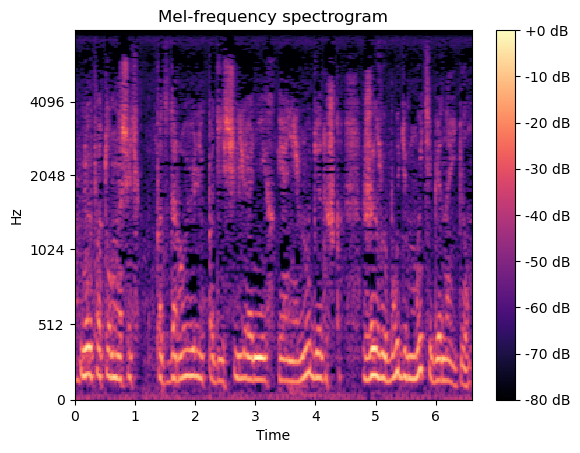

In [8]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=256)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

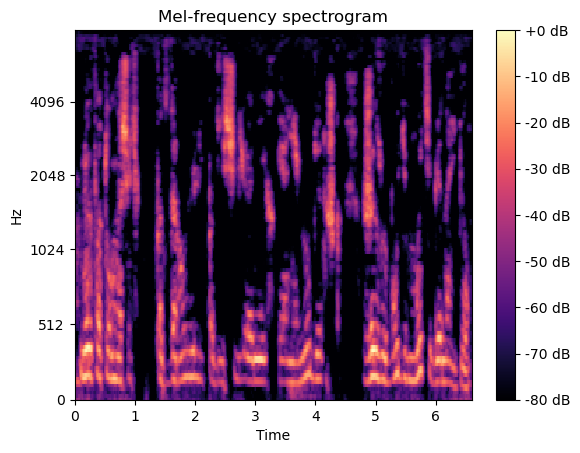

In [10]:
wav_pathname = '020721_VIK1941_Razdorskaya_VIK1941_ann25.wav'
y, sr = librosa.load(wav_pathname)
reduced_noise = nr.reduce_noise(y=y, sr=sr)
S = librosa.feature.melspectrogram(reduced_noise, sr=sr, n_mels=128)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Import manifest

In [2]:
manifest = pd.read_excel('manifest_balanced.xlsx')
manifest = manifest[['path', 'Variant']]

# GridSearchMFCC

In [13]:
def read_audio(path):
    audio, sample_rate = librosa.load(path, sr=44100)
    return audio

In [15]:
manifest['audio'] = manifest['path'].progress_apply(read_audio)

100%|████████████████████████████████████████████████████████████████████████████| 55657/55657 [36:58<00:00, 25.09it/s]


In [29]:
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
for variant in list(manifest['Variant'].unique()):
    train_df, valid_test_df = train_test_split(manifest[manifest['Variant']==variant], test_size=0.3, random_state=55)
    valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=55)
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['audio'].str.len()>0]
valid = valid[valid['audio'].str.len()>0]
test = test[test['audio'].str.len()>0]

Define class for MFCC to be able to create MFCC + delta + delta-delta

In [34]:
class MFCC(BaseEstimator, TransformerMixin):
    def __init__(self, sr=44100, n_mfcc=10):
        self.sr = sr
        self.n_mfcc = n_mfcc

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for x in tqdm(X):
            mfcc = librosa.feature.mfcc(y=x, sr=self.sr, n_mfcc=self.n_mfcc)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)
            combined = np.vstack([mfcc, delta, delta2])
            features.append(np.mean(combined, axis=1))
        return np.array(features)

In [36]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=10)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2'))
])

param_grid = {
    'mfcc__n_mfcc': [13, 20, 40],
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': ['balanced']
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro')
gs.fit(train['audio'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 38022/38022 [23:34<00:00, 26.88it/s]


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mfcc', MFCC()),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__class_weight': ['balanced'],
                         'mfcc__n_mfcc': [13, 20, 40]},
             scoring='f1_macro')

In [37]:
gs_result = pd.concat([pd.DataFrame(gs.cv_results_["params"]), 
                       pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["f1_macro"])],axis=1)

In [38]:
gs_result

,clf__C,clf__class_weight,mfcc__n_mfcc,f1_macro
0,0.1,balanced,13,0.628690
1,0.1,balanced,20,0.722034
2,0.1,balanced,40,0.796148
3,1.0,balanced,13,0.629206
4,1.0,balanced,20,0.722617
5,1.0,balanced,40,0.796880
6,10.0,balanced,13,0.629187
7,10.0,balanced,20,0.722612
8,10.0,balanced,40,0.796792


In [41]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=40)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2', C=1))
])

train_y = train['Variant'].values.reshape(-1,1)
pipe.fit(train['audio'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 38022/38022 [24:22<00:00, 26.00it/s]


Pipeline(steps=[('mfcc', MFCC(n_mfcc=40)), ('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, dual=False, max_iter=10000))])

In [43]:
print(classification_report(test['Variant'], pipe.predict(test['audio'])))

100%|██████████████████████████████████████████████████████████████████████████████| 8152/8152 [05:48<00:00, 23.41it/s]


               precision    recall  f1-score   support

Arkhangelskie       0.88      0.93      0.90       622
   Desninskie       0.78      0.88      0.83       705
      Donskie       0.93      0.93      0.93      1145
  Kostromskie       0.82      0.88      0.85      1195
 Mezhzonalnie       0.77      0.70      0.74       611
 Novgorodskie       0.73      0.59      0.65       568
    Povolzkie       0.78      0.77      0.77      1059
    Pskovskie       0.70      0.73      0.72       971
   Ryazanskie       0.76      0.67      0.71       609
  Seligerskie       0.87      0.86      0.86       667

     accuracy                           0.81      8152
    macro avg       0.80      0.79      0.80      8152
 weighted avg       0.81      0.81      0.81      8152



100%|██████████████████████████████████████████████████████████████████████████████| 8152/8152 [05:29<00:00, 24.78it/s]


<Figure size 3000x1800 with 0 Axes>

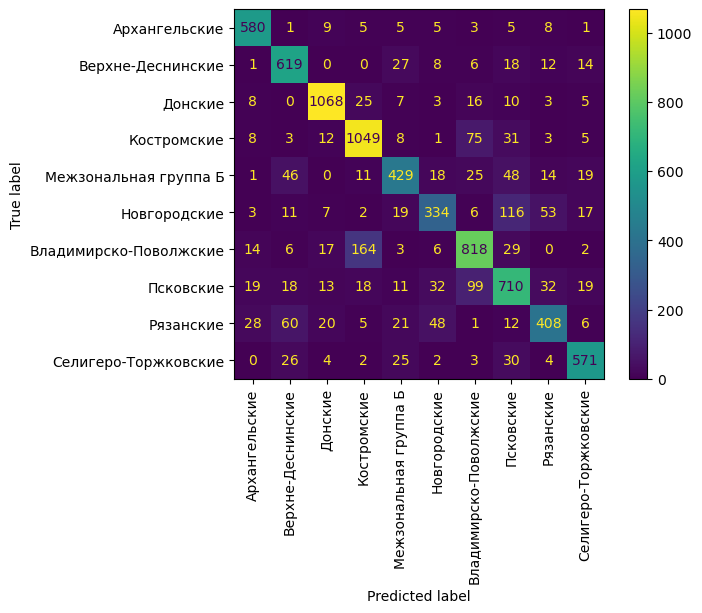

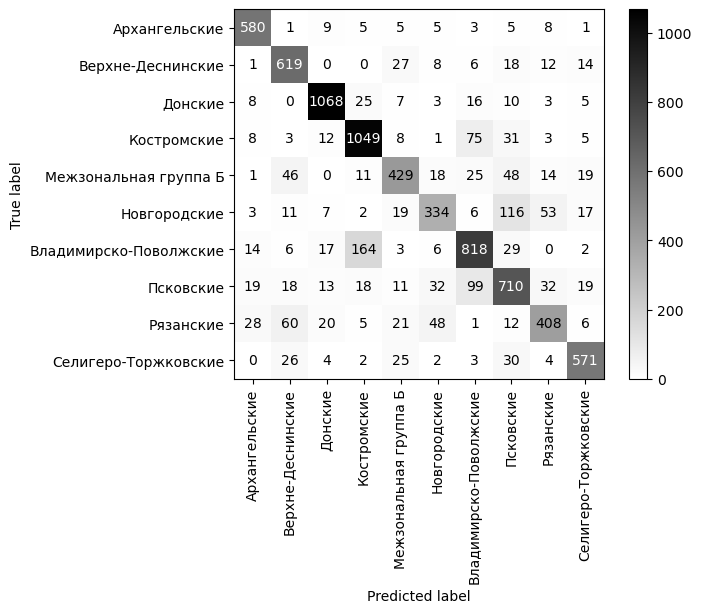

<Figure size 640x480 with 0 Axes>

In [47]:
labs = ['Архангельские', 'Верхне-Деснинские', 'Донские', 'Костромские', 'Межзональная группа Б',
        'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские', 'Селигеро-Торжковские']
plt.figure(figsize=(10, 6), dpi=300)
disp = ConfusionMatrixDisplay.from_predictions(test['Variant'], pipe.predict(test['audio']),
                                        display_labels = labs, xticks_rotation='vertical')
disp = disp.plot(cmap=plt.cm.binary,values_format='g',xticks_rotation='vertical')
plt.show()

# With denoise

In [50]:
def denose_audio(audio):
    return nr.reduce_noise(y=audio, sr=44100)

In [54]:
manifest['audio_denoised'] = manifest['audio'].progress_apply(denose_audio)

100%|██████████████████████████████████████████████████████████████████████████| 55657/55657 [1:33:14<00:00,  9.95it/s]


In [56]:
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
for variant in list(manifest['Variant'].unique()):
    train_df, valid_test_df = train_test_split(manifest[manifest['Variant']==variant], test_size=0.3, random_state=55)
    valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=55)
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['audio'].str.len()>0]
valid = valid[valid['audio'].str.len()>0]
test = test[test['audio'].str.len()>0]

In [58]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=40)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2', C=1))
])

train_y = train['Variant'].values.reshape(-1,1)
pipe.fit(train['audio_denoised'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 38022/38022 [58:35<00:00, 10.81it/s]


Pipeline(steps=[('mfcc', MFCC(n_mfcc=40)), ('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, dual=False, max_iter=10000))])

In [59]:
print(classification_report(test['Variant'], pipe.predict(test['audio_denoised'])))

100%|██████████████████████████████████████████████████████████████████████████████| 8152/8152 [11:29<00:00, 11.82it/s]


               precision    recall  f1-score   support

Arkhangelskie       0.70      0.87      0.78       622
   Desninskie       0.67      0.79      0.72       705
      Donskie       0.83      0.90      0.86      1145
  Kostromskie       0.73      0.81      0.77      1195
 Mezhzonalnie       0.65      0.70      0.67       611
 Novgorodskie       0.65      0.29      0.40       568
    Povolzkie       0.66      0.67      0.67      1059
    Pskovskie       0.61      0.61      0.61       971
   Ryazanskie       0.60      0.31      0.41       609
  Seligerskie       0.73      0.80      0.76       667

     accuracy                           0.70      8152
    macro avg       0.68      0.67      0.66      8152
 weighted avg       0.69      0.70      0.68      8152



100%|██████████████████████████████████████████████████████████████████████████████| 8152/8152 [11:03<00:00, 12.28it/s]


<Figure size 3000x1800 with 0 Axes>

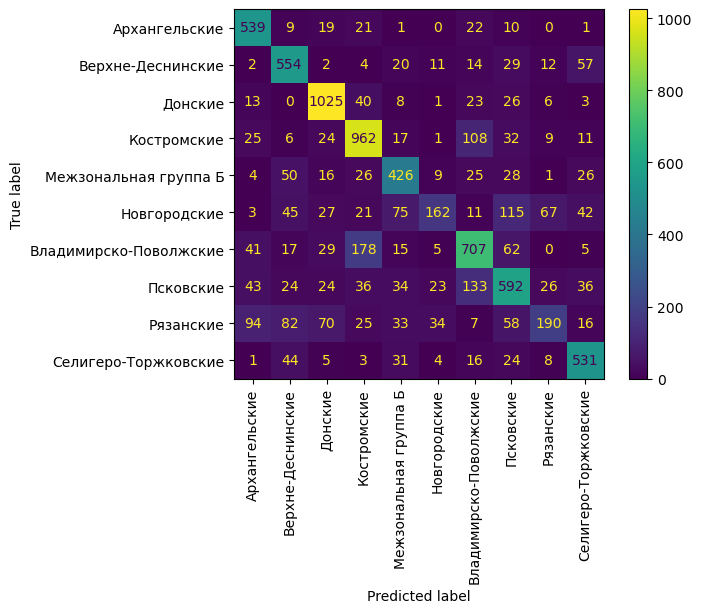

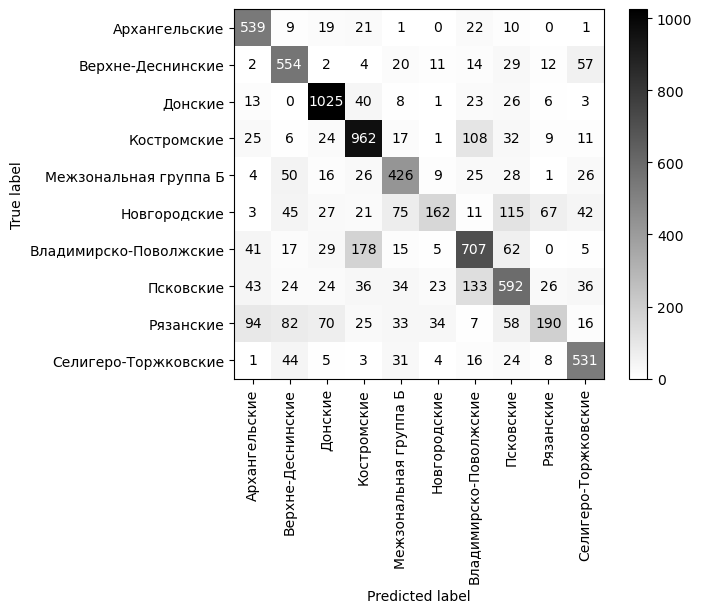

In [60]:
labs = ['Архангельские', 'Верхне-Деснинские', 'Донские', 'Костромские', 'Межзональная группа Б',
        'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские', 'Селигеро-Торжковские']
plt.figure(figsize=(10, 6), dpi=300)
disp = ConfusionMatrixDisplay.from_predictions(test['Variant'], pipe.predict(test['audio_denoised']),
                                        display_labels = labs, xticks_rotation='vertical')
disp = disp.plot(cmap=plt.cm.binary,values_format='g',xticks_rotation='vertical')
plt.show()